## Create Hadoop Spark Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"

In [ ]:
import findspark
findspark.init()

## Imports

In [ ]:
import glob as glob

## Setup Spark Session

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType
from pyspark.sql.functions import col, when, count, isnan, variance, skewness, lit , explode , array 

In [ ]:
spark = SparkSession.builder.appName('mit-bih-arff').getOrCreate()

## Denoise

In [ ]:
import pywt

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

## Constants

In [ ]:
allowed_labels = ['N', 'L', 'R', 'A', 'V']
allowed_labels_map = {}
reverse_allowed_labels_map = {}
window = 180
for i in range(len(allowed_labels)):
  allowed_labels_map[allowed_labels[i]] = i
  reverse_allowed_labels_map[i] = allowed_labels[i]

In [ ]:
def splitAnnotations(row):
    temp = row.value.strip().split()
    return [temp[1], allowed_labels_map[temp[2]]]

## Visualizing Data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def showECG(df):
  n = 500
  p = plt.figure(figsize=(15, 8))
  plot_data = df.select(['Upper']).take(n)
  x_axis = [i for i in range(n)]
  y_axis = [row['Upper'] for row in plot_data]
  plt.plot(x_axis, y_axis)
  plt.show()

## Process

In [ ]:
def process(data, ann):
  annotations = spark.read.text(ann)
  sample_label_map = annotations.rdd.filter(lambda x: x.value.strip().split()[2] in allowed_labels).map(splitAnnotations).toDF()
  ann_df = sample_label_map.select([col('_1').alias('Sample'), col('_2').alias('Label')])
  ann_df = ann_df.na.drop()
  ann_df = ann_df.distinct()
  
  df = spark.read.csv(data, header=True, inferSchema=True)
  newcols = []
  newcols.append(col(df.columns[0]).alias('Sample'))
  newcols.append(col(df.columns[1]).alias('Upper'))
  df = df.select(newcols)
  df = df.na.drop()
  df = df.distinct()
  labelled_df = df.join(ann_df, 'Sample')
  return labelled_df, df

## 100.csv

+------+-----+-----+
|Sample|Upper|Label|
+------+-----+-----+
| 15607| 1182|    0|
| 52506| 1185|    0|
|147832| 1212|    0|
|231357| 1191|    0|
|281955| 1223|    0|
+------+-----+-----+
only showing top 5 rows



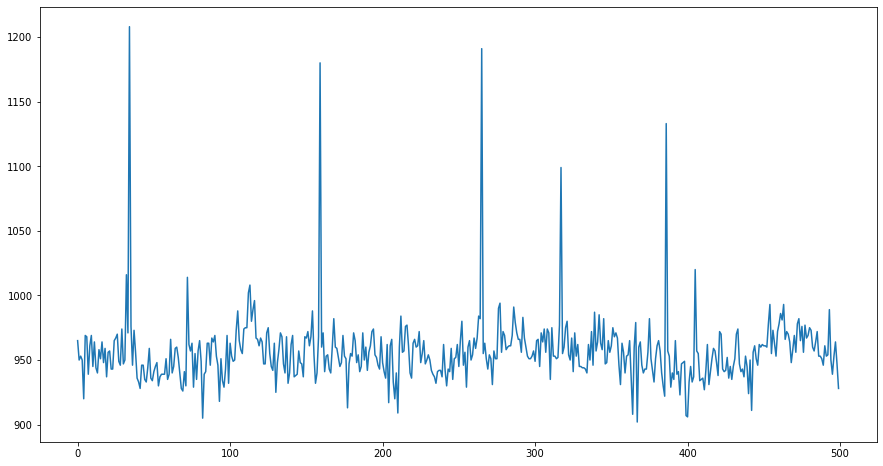

In [ ]:
data_100 = glob.glob('/content/drive/MyDrive/Colab Notebooks/MITBIH/100.csv')
ann_100 = glob.glob('/content/drive/MyDrive/Colab Notebooks/MITBIH/100annotations.txt')
temp_df, temp_df_all = process(data_100, ann_100)
temp_df.show(5)
showECG(temp_df_all)

## 231.csv

+------+-----+-----+
|Sample|Upper|Label|
+------+-----+-----+
|227846| 1323|    2|
|312841| 1394|    0|
|364553| 1374|    0|
|401669| 1313|    2|
|549809| 1304|    2|
+------+-----+-----+
only showing top 5 rows



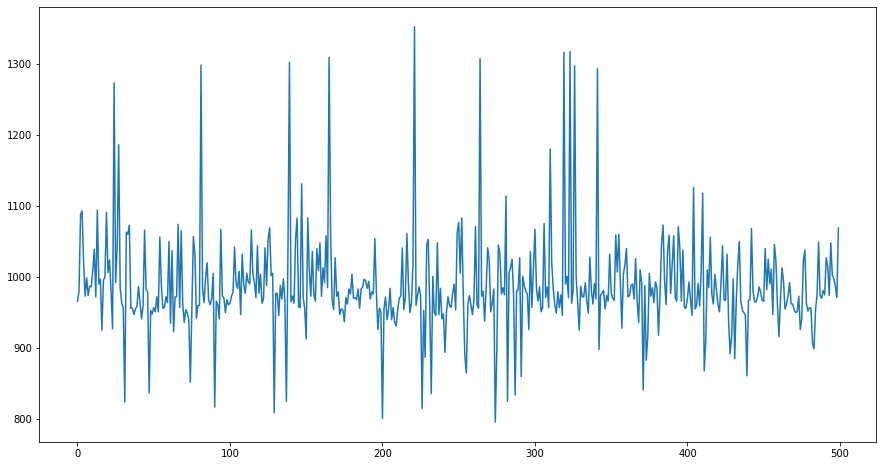

In [ ]:
data_231 = glob.glob('/content/drive/MyDrive/Colab Notebooks/MITBIH/231.csv')
ann_231 = glob.glob('/content/drive/MyDrive/Colab Notebooks/MITBIH/231annotations.txt')
temp_df, temp_df_all = process(data_231, ann_231)
temp_df.show(5)
showECG(temp_df_all)

## For all files

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
datasets = glob.glob('/content/drive/MyDrive/Colab Notebooks/MITBIH/*.csv')

In [ ]:
schema = StructType([
  StructField("Upper", IntegerType(), True),
  StructField("Label", IntegerType(), True),
])

In [ ]:
pd_df_labelled = pd.DataFrame([])

for file in datasets[:20]:
    annsFileName = file[:-4] + 'annotations.txt'
    l_df, df = process(file, annsFileName)
    # l_df -> sample, upper, label
    # df -> sample, upper
    pd_l_df = l_df.toPandas()
    pd_df = df.toPandas()
    total = pd_df.shape[0]
    for row in pd_l_df.iterrows():
      sample = row[1]['Sample']
      if(sample >= window and sample + window <= total):
        req_rows = pd_df.loc[(pd_df['Sample'] >= sample - window) & (pd_df['Sample'] < sample + window)]
        req_rows = req_rows.sort_values('Sample')
        features = np.array([x[0] for x in req_rows[['Upper']].to_numpy()])
        features = np.append(features, row[1])
        pd_df_labelled = pd_df_labelled.append(pd.Series(features), ignore_index = True)

In [ ]:
print(pd_df_labelled.shape)

(35766, 363)


In [ ]:
pd_df_labelled.head()

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,362
0,962.0,962.0,961.0,959.0,960.0,963.0,965.0,965.0,965.0,964.0,...,950.0,953.0,952.0,953.0,952.0,949.0,950.0,15607.0,1182.0,0.0
1,956.0,960.0,959.0,961.0,961.0,962.0,965.0,970.0,971.0,969.0,...,950.0,952.0,954.0,953.0,950.0,950.0,951.0,52506.0,1185.0,0.0
2,945.0,947.0,945.0,945.0,942.0,942.0,941.0,944.0,945.0,944.0,...,972.0,975.0,980.0,979.0,979.0,976.0,976.0,147832.0,1212.0,0.0
3,949.0,955.0,957.0,957.0,954.0,954.0,957.0,962.0,963.0,964.0,...,965.0,967.0,969.0,968.0,968.0,967.0,965.0,231357.0,1191.0,0.0
4,956.0,958.0,957.0,954.0,959.0,961.0,966.0,969.0,970.0,972.0,...,966.0,968.0,969.0,963.0,961.0,961.0,961.0,281955.0,1223.0,0.0


In [ ]:
pd_df_labelled.count()

0      35766
1      35766
2      35766
3      35766
4      35766
       ...  
358    35766
359    35766
360    35766
361    35766
362    35766
Length: 363, dtype: int64

In [ ]:
pd_df_labelled.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            353, 354, 355, 356, 357, 358, 359, 360, 361, 362],
           dtype='int64', length=363)

## Balance data

In [ ]:
from sklearn.utils import resample

0.0    27539
1.0     4613
2.0     2165
4.0     1296
3.0      153
Name: 362, dtype: int64


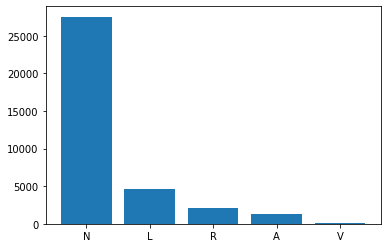

In [ ]:
X_train_df = pd.DataFrame(pd_df_labelled)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.bar(allowed_labels, per_class)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 362, dtype: int64


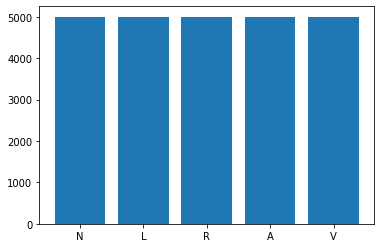

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.bar(allowed_labels, per_class)
plt.show()

## CNN Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 363)
X_test  :  (5000, 363)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 362, 1) (5000, 362, 1)


In [ ]:
model = Sequential()

# Adding a Convolution Layer C1
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(362, 1)))

# Adding an Average Pooling Layer S2
model.add(AvgPool1D(pool_size=3, strides=2))

# Adding a Convolution Layer C3
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))

# Adding an Average Pooling Layer S4
model.add(AvgPool1D(pool_size=3, strides=2))

# Adding a Convolution Layer C5
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))

# Adding an Average Pooling Layer S6
model.add(AvgPool1D(pool_size=3, strides=2))

# Adding a Convolution Layer C7
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))

# Adding an Average Pooling Layer S8
model.add(AvgPool1D(pool_size=3, strides=2))

# Flattening the layer 
model.add(Flatten())

# Dropout the layer S9
model.add(Dropout(0.5))

# Adding a Dense layer with regularization l2(0.0001)# S10
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

# Adding a Dense layer with regularization l2(0.0001)# S11
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

# Adding a Softmax layer S12
model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 362, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 180, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 180, 32)           7712      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 64)           0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, batch_size=36, epochs=10, verbose=1, validation_data=(test_x, test_y))

Epoch 1/10
556/556 [==============================] - 61s 107ms/step - loss: 4.4037 - accuracy: 0.7219 - val_loss: 0.2064 - val_accuracy: 0.9192
Epoch 2/10
556/556 [==============================] - 63s 113ms/step - loss: 0.2537 - accuracy: 0.9184 - val_loss: 0.1448 - val_accuracy: 0.9564
Epoch 3/10
556/556 [==============================] - 63s 114ms/step - loss: 0.1837 - accuracy: 0.9420 - val_loss: 0.1010 - val_accuracy: 0.9630
Epoch 4/10
556/556 [==============================] - 65s 117ms/step - loss: 0.1515 - accuracy: 0.9570 - val_loss: 0.0957 - val_accuracy: 0.9758
Epoch 5/10
556/556 [==============================] - 63s 114ms/step - loss: 0.1363 - accuracy: 0.9617 - val_loss: 0.0778 - val_accuracy: 0.9790
Epoch 6/10
556/556 [==============================] - 69s 125ms/step - loss: 0.1211 - accuracy: 0.9657 - val_loss: 0.0757 - val_accuracy: 0.9794
Epoch 7/10
556/556 [==============================] - 70s 126ms/step - loss: 0.1029 - accuracy: 0.9721 - val_loss: 0.0600 - val_ac

In [ ]:
model.evaluate(test_x, test_y)

157/157 [==============================] - 4s 23ms/step - loss: 0.0482 - accuracy: 0.9894


[0.04819237440824509, 0.9894000291824341]

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CNN-Model-For-Labelling')

## Previous Model

In [ ]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [ ]:
records_per_label = 5000

# Assign a column with random values
df_temp = df_labelled.withColumn('rand_col', F.rand())
sample_df1 = df_temp.withColumn("row_num",row_number().over(Window.partitionBy("Label")\
                .orderBy("rand_col"))).filter(col("row_num")<=records_per_label)\
                .drop("rand_col", "row_num")

sample_df1.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 5000|
|    1| 4615|
|    3|  153|
|    2| 2166|
|    4| 1296|
+-----+-----+



In [ ]:
major_df = sample_df1.filter(col("Label") == 0)
combined_df = major_df

for i in range(1,5):
  minor_df = sample_df1.filter(col("Label") == i)
  ratio = int(major_df.count()/minor_df.count())
  a = range(ratio)
  # duplicate the minority rows
  oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
  # combine both oversampled minority rows and previous majority rows 
  combined_df = combined_df.unionAll(oversampled_df)

In [ ]:
combined_df.groupBy("Label").count().show()

+-----+-----+
|Label|count|
+-----+-----+
|    0| 5000|
|    1| 4615|
|    3| 4896|
|    2| 4332|
|    4| 3888|
+-----+-----+



In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [ ]:
(train, test) = combined_df.randomSplit([0.8, 0.2])

# Merge all features into one column
assembler = VectorAssembler(inputCols=['Upper', 'Lower'], outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

In [ ]:
mlp = LogisticRegression(labelCol='Label', family="multinomial")
mlp.setMaxIter(20)

model = mlp.fit(train)
model.setFeaturesCol("features")

# model_path = "/content/drive/MyDrive/Colab Notebooks/CNN_Model/"
# model.save(model_path)

LogisticRegressionModel: uid=LogisticRegression_2c20e021c7e6, numClasses=5, numFeatures=2

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/LR-model')

In [ ]:
predictions = model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")

In [ ]:
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))

Test Accuracy = 0.216939


In [ ]:
ovrModel.save('/content/drive/MyDrive/Colab Notebooks/ecg-model')

In [ ]:
df_main_classifier = assembler.transform(df_main)
final_df = ovrModel.transform(df_main_classifier)

In [ ]:
final_df.printSchema()

root
 |-- Upper: integer (nullable = true)
 |-- Lower: integer (nullable = true)
 |-- Label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: string (nullable = true)
 |-- prediction: double (nullable = true)



In [ ]:
final_df.count()

13000000

## Export Dataframe to ARFF

> Indented block



In [ ]:
!pip install arff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4968 sha256=d0b289016ea9dd3aaa9a6bb5949482d140edaa8d984dfa44e825039355a4d120
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


In [ ]:
import arff

In [ ]:
data = []
for file in datasets[:1]:
    df = pd.read_csv(file)
    df.columns = ['Sample', 'Upper', 'Lower']
    count = 0
    for row in df.iterrows():
      sample = row[1]['Sample']
      if(sample >= window + 1 and sample + window + 1 <= total):
        count += 1
        req_rows = df.loc[(df['Sample'] >= sample - window - 1) & (df['Sample'] < sample + window + 1)]
        req_rows = req_rows.sort_values('Sample')
        features = np.array([x[0] for x in req_rows[['Upper']].to_numpy()])
        features = np.reshape(features, (1, 362))
        data.append(features)
      if(count == 20000):
        break

In [ ]:
data

[array([[ 995,  995,  995,  995,  995,  995,  995,  995, 1000,  997,  995,
          994,  992,  993,  992,  989,  988,  987,  990,  993,  989,  988,
          986,  988,  993,  997,  993,  986,  983,  977,  979,  975,  974,
          972,  969,  969,  969,  971,  973,  971,  969,  966,  966,  966,
          966,  967,  965,  963,  967,  969,  969,  968,  967,  963,  966,
          964,  968,  966,  964,  961,  960,  957,  952,  947,  947,  943,
          933,  927,  927,  939,  958,  980, 1010, 1048, 1099, 1148, 1180,
         1192, 1177, 1128, 1058,  991,  951,  937,  939,  950,  958,  959,
          957,  955,  958,  959,  961,  962,  960,  957,  956,  959,  955,
          957,  958,  957,  958,  959,  958,  958,  955,  953,  957,  959,
          963,  960,  960,  958,  956,  957,  956,  955,  953,  953,  956,
          958,  958,  958,  956,  954,  959,  959,  958,  958,  957,  957,
          956,  958,  956,  954,  953,  954,  955,  958,  960,  957,  958,
          955,  958,  957

In [ ]:
temp = []
for i in range(len(data)):
  prediction = np.argmax(model.predict(data[i])[0])
  temp.append([data[i][0][181], reverse_allowed_labels_map[prediction]])



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


KeyboardInterrupt: ignored

In [ ]:

temp_df = pd.DataFrame(temp)
temp_df.columns = ['Upper', 'Label']
temp_df.head()

,Upper,Label
0,951,A
1,952,A
2,952,A
3,951,A
4,950,A


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/arff-dataset/final.arff', 'w') as creating_new_csv_file:
  pass
arff.dump('/content/drive/MyDrive/Colab Notebooks/arff-dataset/final.arff', temp_df.values, relation='MIT-BIH', names=temp_df.columns)

## Plots


In [ ]:
import numpy as np

In [ ]:
file_arff = arff.load('/content/drive/MyDrive/Colab Notebooks/arff-dataset/final.arff') 

In [ ]:
y = []
x = []
count = 0
for row in file_arff:
  upper = count
  label = row[1]
  x.append(upper)
  y.append(label)
  count += 1
classes = np.unique(y)

In [ ]:
np.array(x).shape

(11829,)

In [ ]:
classes.shape

(5,)

<BarContainer object of 11829 artists>

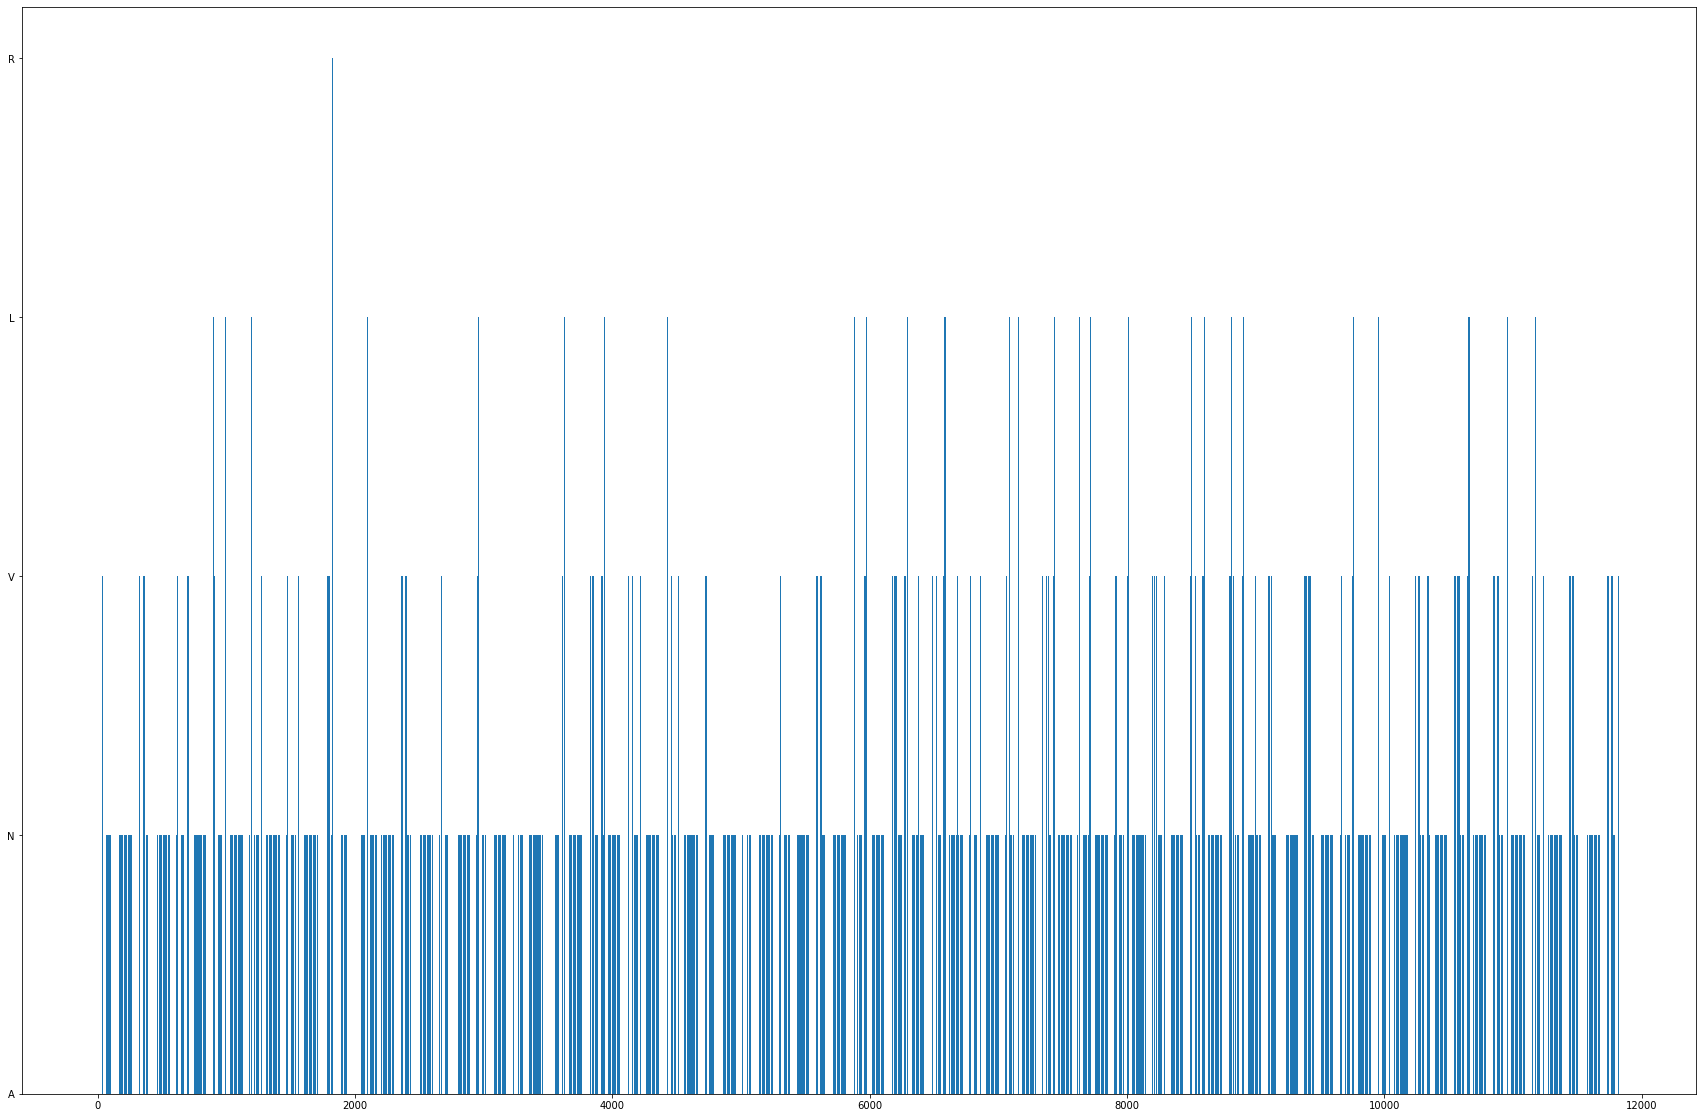

In [ ]:
plt.figure(figsize=(30,20))
plt.bar(x, y)